In [12]:
#importing libraries
import numpy as np
from sklearn import datasets
import torch
import torch.nn as nn
import torch.optim as optim
import torchbnn as bnn
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
import pandas as pd

#setting models to run on gpu
is_available = torch.cuda.is_available()
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")


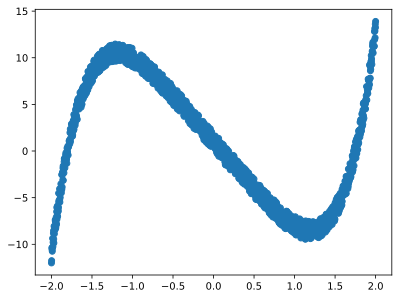

In [2]:
#creating dataset
X = torch.linspace(-2, 2, 2000)
y = X.pow(5) - 10*X + 2*torch.rand(X.size())

X = torch.unsqueeze(X, dim=1)
y = torch.unsqueeze(y, dim=1)

x_train, x_test, y_train, y_test = train_test_split(X, y, train_size=0.8, test_size=0.2, random_state=1)

plt.scatter(x_train.data.numpy(), y_train.data.numpy())
plt.show()

x_train, x_test, y_train, y_test = x_train.to(device), x_test.to(device), y_train.to(device), y_test.to(device)

In [3]:
def clean_target(x):
    return x.pow(5) - 10 * x.pow(1)+1


def target(x):
    return x.pow(5) - 10 * x.pow(1) + 2*torch.rand(x.size())


In [4]:
#creating 10 models, ranging between 100 and 1000 neurones per model - I'm going to test how accurate each one is
no_of_epochs = np.array([2500])
models = [nn.Sequential(
    bnn.BayesLinear(prior_mu=0, prior_sigma=0.1,
                    in_features=1, out_features=1000),
    nn.ReLU(),
    bnn.BayesLinear(prior_mu=0, prior_sigma=0.1,
                    in_features=1000, out_features=1),
).to(device) for _ in range(len(no_of_epochs))]


In [5]:
mse_loss = nn.MSELoss().to(device) #mean standard error - indicates model's accuracy
kl_loss = bnn.BKLLoss(reduction='mean', last_layer_only=False).to(device) #kullback-leibler divergence - indicates model's uncertainty
kl_weight = 0.01 #indicates importance of kl-divergence wrt mse_loss

optimizers = [optim.Adam(model.parameters(), lr=0.01) for model in models] #optimisers for models - good idea to learn more of this later, but this is now engrained in them

In [6]:
mse_losses, kl_divergences, cost_values = np.array([]), np.array([]), np.array([])

print("With 1000 neurones:")
for i in range(len(models)): #working with epochs (from 500 to 5000 epochs)
    for step in range(no_of_epochs[i]):
        predictions = models[i](x_train)
        mse = mse_loss(predictions, y_train)
        kl = kl_loss(models[i])
        cost = mse + kl_weight*kl

        optimizers[i].zero_grad()  # resets optimiser parameters for next epoch
        cost.backward()  # computes cost function gradients wrt to model's parameters (weights, biases, etc)
        optimizers[i].step()  # updates model parameters - this is the learning part of the model

    mse_losses = np.append(mse_losses, mse.item())
    kl_divergences = np.append(kl_divergences, kl.item())
    cost_values = np.append(cost_values, cost.item())

    print(f"\tWith {no_of_epochs[i]} epochs, MSE, KL, Cost = {mse.item():2.2f}, {kl.item():2.2f}, {cost.item():2.2f}")

model = models[np.argmin(cost_values)].to("cpu")
print(np.min(no_of_epochs), mse_losses[np.argmin(cost_values)], kl_divergences[np.argmin(cost_values)], cost_values[np.argmin(cost_values)])

With 1000 neurones:
	With 2500 epochs, MSE, KL, Cost = 0.76, 11.59, 0.87
2500 0.7589413523674011 11.588217735290527 0.8748235106468201


In [7]:
#allocating test data back to cpu for numpy to work with them
x_test = torch.sort(x_test.to("cpu"), dim=0)[0]
y_test = target(x_test.to("cpu"))

final_predictions = np.array([model(x_test).data.numpy() for _ in range(10000)])[:,:,0].T
print(no_of_epochs[np.argmin(cost_values)], mse_losses[np.argmin(cost_values)], kl_divergences[np.argmin(cost_values)], cost_values[np.argmin(cost_values)])

2500 0.7589413523674011 11.588217735290527 0.8748235106468201


In [8]:
mean_values = np.array([final_predictions[i].mean() for i in range(len(final_predictions))])
std_values = np.array([final_predictions[i].std() for i in range(len(final_predictions))])

print(len(mean_values))

400


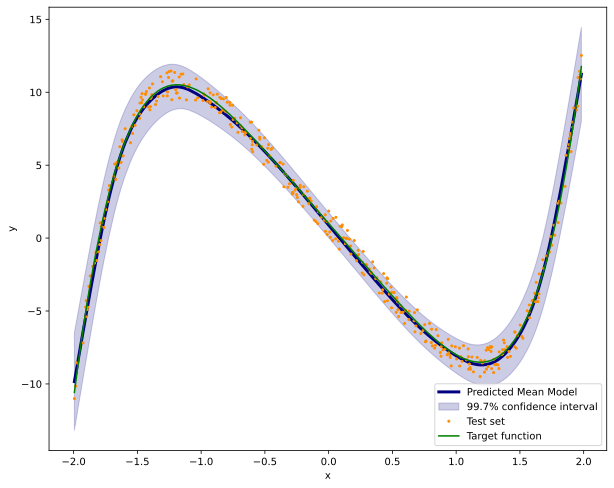

In [9]:
plt.figure(figsize=(10, 8))
plt.plot(x_test.data.numpy(), mean_values, color='navy',
        lw=3, label='Predicted Mean Model')
plt.fill_between(x_test.data.numpy().T[0], mean_values-3.0*std_values, mean_values +
                3.0*std_values, alpha=0.2, color='navy', label='99.7% confidence interval')
plt.plot(x_test.data.numpy(), y_test.data.numpy(), '.',
        color='darkorange', markersize=4, label='Test set')
plt.plot(x_test.data.numpy(), clean_target(x_test).data.numpy(),
        color='green', markersize=4, label='Target function')
plt.legend()
plt.xlabel('x')
plt.ylabel('y')

plt.savefig("data/nn_pred.pdf")
plt.show()


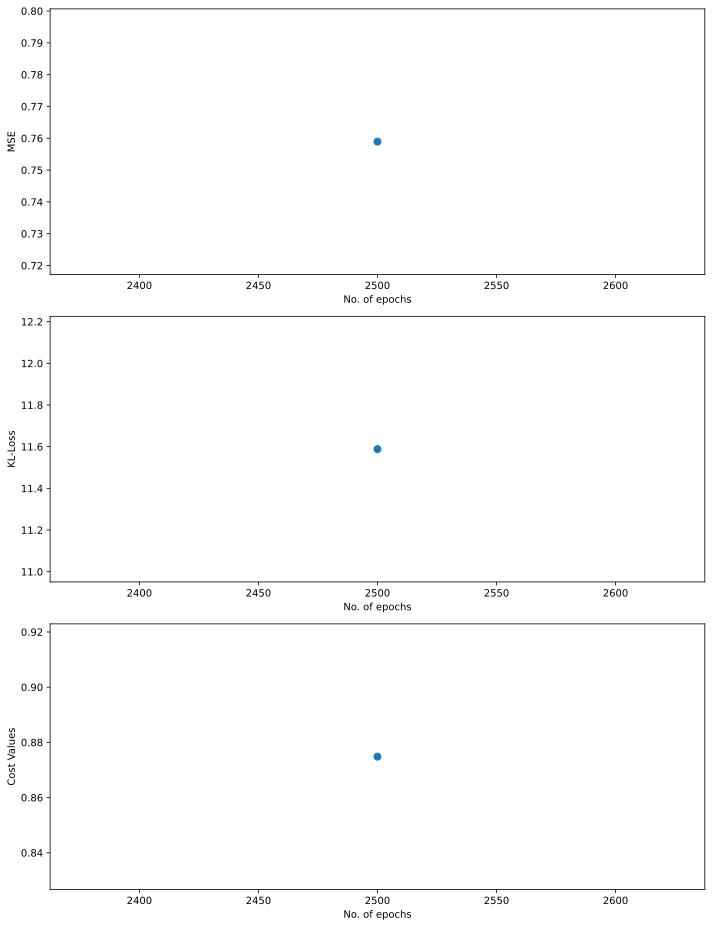

In [10]:
#plotting mse and kl relations with epochs
fig = plt.figure(figsize=(10, 13))
ax1, ax2, ax3 = plt.subplot(3, 1, 1), plt.subplot(3, 1, 2), plt.subplot(3, 1, 3)

ax1.plot(
    no_of_epochs,
    mse_losses,
    ls="None",
    marker='o',
    markersize=7
)

ax2.plot(
    no_of_epochs,
    kl_divergences,
    ls="None",
    marker='o',
    markersize=7
)

ax3.plot(
    no_of_epochs,
    cost_values,
    ls="None",
    marker='o',
    markersize=7
)

xlabel = "No. of epochs"

ax1.set_xlabel(xlabel)
ax2.set_xlabel(xlabel)
ax3.set_xlabel(xlabel)

ax1.set_ylabel("MSE")
ax2.set_ylabel("KL-Loss")
ax3.set_ylabel("Cost Values")

# fig.suptitle(f"1000 Neurones")
fig.tight_layout()

fig.savefig(f"data/1000_neurones.pdf")
# plt.show()

In [22]:
print(x_test[:, 0].shape, std_values.shape)


df = pd.DataFrame(
    {'x':x_test[:, 0], "std":std_values[:]}
).sort_values("std", ascending=False)

worst_x_values = df.iloc[:50, 0]
worst_x_values

f = lambda x: x.pow(5) -10*x + 2*torch.rand(x.size())


torch.Size([400]) (400,)


0     -1.993997
1     -1.983992
2     -1.977989
3     -1.965983
399    1.981991
398    1.977989
397    1.973987
4     -1.925963
396    1.971986
395    1.967984
394    1.955978
393    1.951976
5     -1.905953
6     -1.903952
7     -1.901951
392    1.943972
8     -1.893947
9     -1.887944
10    -1.879940
391    1.921961
390    1.913957
11    -1.869935
389    1.909955
388    1.901951
387    1.895948
386    1.893947
12    -1.849925
385    1.889945
384    1.885943
383    1.879940
13    -1.835918
14    -1.825913
382    1.861931
15    -1.817909
381    1.853927
16    -1.803902
17    -1.795898
18    -1.791896
380    1.821911
19    -1.785893
20    -1.783892
379    1.809905
21    -1.777889
378    1.799900
377    1.797899
22    -1.761881
23    -1.759880
24    -1.747874
376    1.773887
375    1.765883
Name: x, dtype: float32